### Make Parsing and Preprocessing Functions

In [1]:
import os

DATA_DIR = os.path.join("english")

In [2]:
next(os.walk(os.path.join(DATA_DIR, 'Durian')))

('english\\Durian',
 [],
 ['aligned.swc',
  'audio.ogg',
  'audiometa.txt',
  'info.json',
  'wiki.html',
  'wiki.txt',
  'wiki.xml'])

In [3]:
import xml.etree.ElementTree as ET
from typing import List

import numpy as np


class PronunciationTiming(object):

    def __init__(self, word: str, start: int, end: int) -> None:
        self.word = word
        self.start = start
        self.end = end

class SWC(object):

    def __init__(self, swc_path: str) -> None:
        self.tree = ET.parse(swc_path)
        self.timings = []

    def get_timings(self) -> List[PronunciationTiming]:
        if len(self.timings) > 0:
            return self.timings
        # https://www.geeksforgeeks.org/xml-parsing-python/
        root = self.tree.getroot()
        doc = root.find('d')

        for p in doc.findall('p'):
            for s in p.findall('s'):
                for t in s.findall('t'):
                    for n in t.findall('n'):
                        attribs = n.attrib
                        if 'pronunciation' not in attribs \
                            or 'start' not in attribs or 'end' not in attribs:
                            continue
                        word = attribs['pronunciation'].lower()
                        self.timings.append(PronunciationTiming(
                            word,
                            int(attribs['start']),
                            int(attribs['end'])))
        return self.timings

In [4]:
from typing import Tuple

from pydub import AudioSegment


def split_clip(audio: AudioSegment, swc: SWC
               ) -> Tuple[List[str], List[AudioSegment]]:
    words = []
    clips = []
    for p in swc.get_timings():
        words.append(p.word)
        clip = audio[p.start:p.end]
        # https://github.com/jiaaro/pydub/blob/master/API.markdown#audiosegmentget_array_of_samples
        # clip = audio[p.start:p.end].get_array_of_samples()
        # fp_arr = np.array(clip).T.astype(np.float32)
        # fp_arr /= np.iinfo(clip.typecode).max
        clips.append(clip)
    return words, clips

# audio = AudioSegment.from_ogg('english/Durian/audio.ogg')
# print(audio.channels, audio.frame_rate)
# swc = SWC('english/Durian/aligned.swc')
# split_clip(audio, swc)

In [5]:
from typing import Optional


class PronunciationClip(object):
    def __init__(self, word: str, audio: AudioSegment) -> None:
        self.word = word
        self.audio = audio

    def __repr__(self) -> str:
        return f"PronunciationClip({repr(self.word)}, {repr(self.audio)})"

def load_utterances(limit: Optional[int] = 5000, vocab: List[str] = None
                    ) -> List[PronunciationClip]:
    clips = []

    for dir in os.listdir(DATA_DIR):
        path = os.path.join(DATA_DIR, dir)
        if not os.path.isdir(path):
            continue
        files = os.listdir(path)
        if 'audio.ogg' not in files or 'aligned.swc' not in files:
            continue
        try:
            audio = AudioSegment.from_ogg(os.path.join(path, 'audio.ogg'))
        except:  # noqa: E722
            print(f'Failed to decode file: {os.path.join(path, "audio.ogg")}')
            continue
        swc = SWC(os.path.join(path, 'aligned.swc'))
        words, pcms = split_clip(audio, swc)
        for w, c in zip(words, pcms):
            # skip words less than 4 chars long or not in vocab
            if len(w) < 4 \
                or vocab is not None and w not in vocab:
                continue
            clips.append(PronunciationClip(w, c))

        if limit is not None and len(clips) > limit:
            break
    return clips

In [6]:
# clips = load_utterances(None) # 50 minutes to load 100,000 clips
# print(len(clips))
# clips[0]

#### Specifically Audio Manipulation

In [12]:
def make_noise_playlist(path: os.PathLike, limit: int = 0) -> List[AudioSegment]:
    clips = []
    for f in os.listdir(path):
        if not f.endswith('wav'):
            continue
        file_path = os.path.join(path, f)
        clips.append(AudioSegment.from_file(file_path))
        if limit > 0 and len(clips) > limit:
            break
    return clips


# music_clips = make_noise_playlist(os.path.join('audio', 'music'), 200)
# outdoor_clips = make_noise_playlist(os.path.join('audio', 'outside_rural'))

In [13]:
# https://github.com/mcdermottLab/pycochleagram
import pycochleagram.cochleagram as cgram
from scipy import ndimage

N_FILTERS = 50
LO_LIM = 30
HI_LIM = 7860
SAMPLE_RATE = 16000

def gen_clip(audio: AudioSegment, duration: int = 2000) -> AudioSegment:
    clip = AudioSegment.silent(duration=duration, frame_rate=SAMPLE_RATE)
    audio_duration = len(audio)
    offset = max(0, duration / 2 - (audio_duration / 2))
    return clip.overlay(audio, offset)

def audio_to_cgram(audio: AudioSegment) -> np.array:
    # TODO: find audio input type for cochleagram (8-bit integer PCM?)
    arr = np.array(audio.get_array_of_samples())
    return cgram.human_cochleagram(arr, audio.frame_rate or SAMPLE_RATE,
                                   N_FILTERS, LO_LIM, HI_LIM, 4, downsample=200)

def aa_cgram(cochleagram: np.ndarray, size: int = 256) -> np.ndarray:
    f, t = cochleagram.shape
    kx = size / f
    ky = size / t
    return ndimage.zoom(cochleagram, (kx, ky))

# a = gen_clip(clips[0].audio)
# c = audio_to_cgram(a)
# aa = aa_cgram(c)
# c.shape, aa.shape # 211x400, 256x256


c:\Users\nwong\Documents\nick-repo\.conda\Lib\site-packages\pycochleagram-0.1-py3.11.egg\pycochleagram\erbfilter.py:8: RuntimeWarning: pycochleagram using non-interactive Agg matplotlib backend
  from pycochleagram import utils


In [14]:
import array


def overlay_noise(snr: float, signal: AudioSegment, noise: AudioSegment
                  ) -> AudioSegment:
    # signal = signal.normalize()
    # noise = noise.normalize()
    # gain = snr - signal.dBFS + noise.dBFS
    # scaled_noise = noise.apply_gain(-gain)
    # print(np.min(s), np.max(s))
    # print(np.min(ss), np.max(ss))
    signal_rms = signal.rms
    noise_rms = noise.rms
    scaling_factor = signal_rms / noise_rms * 10**(-snr/20)
    noise_np = np.array(noise.set_channels(1).get_array_of_samples())
    noise_samples = noise_np * scaling_factor
    # new_noise_rms = np.sqrt(np.mean(np.square(noise_samples)))
    # new_snr = (signal_rms / new_noise_rms) ** 2
    noise_array = array.array(signal.array_type, np.round(noise_samples).astype(np.int32))
    scaled_noise = noise._spawn(noise_array)
    return signal.overlay(scaled_noise, loop=True)

# noise = AudioSegment.from_file('audio/outside_rural/snipped119_start_240_end_250.wav')
# overlay_noise(2.0, gen_clip(clips[0].audio), noise)

### Count word frequencies to consider which data points we will keep

{'whiskers': [<matplotlib.lines.Line2D at 0x17d81714260>,
 'caps': [<matplotlib.lines.Line2D at 0x17d81717c80>,
 'boxes': [<matplotlib.lines.Line2D at 0x17d81714560>],
 'medians': [<matplotlib.lines.Line2D at 0x17d817176b0>],
 'fliers': [<matplotlib.lines.Line2D at 0x17d81717440>],
 'means': []}

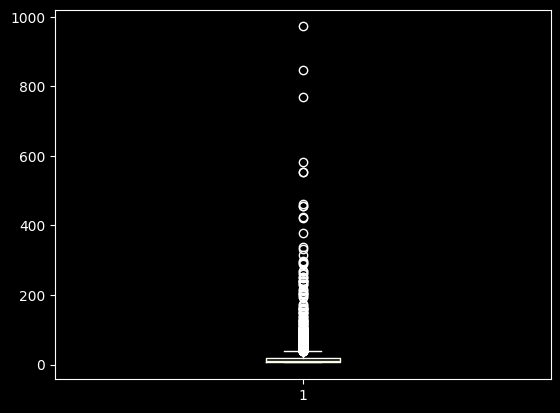

In [10]:
import matplotlib.pyplot as plt

freq_dict = {}
# for pc in clips:
#     freq_dict[pc.word] = freq_dict.get(pc.word, 0) + 1

freqs = list(filter(lambda x: 5 < x < 200000, freq_dict.values()))

plt.boxplot(freqs)

In [7]:
def filter_clips(clips: List[PronunciationClip], min_freq: int = 20,
                 max_freq: int = 200) -> List[PronunciationClip]:
    freq_dict = {}
    for pc in clips:
        freq_dict[pc.word] = freq_dict.get(pc.word, 0) + 1
    included_words = list(filter(lambda w: min_freq < freq_dict[w] < max_freq,
                                 freq_dict.keys()))
    return list(filter(lambda c: c.word in included_words, clips))

In [14]:
wf = dict(filter(lambda x: 50 < x[1] < 300, freq_dict.items()))
print(f'{len(wf)} words remain after filtering')

with open('vocab.txt', 'w') as f:
    f.write("\n".join(wf.keys()))
    print('wrote vocabulary file')

NameError: name 'freq_dict' is not defined

### Save Audio Files

In [ ]:
# vocab = load_vocab()
# clips = load_utterances(20_000, vocab)

In [11]:
# path = os.path.join('parsed_files', 'raw_clips')
# utter_path = os.path.join('parsed_files', 'raw_utterance')
# os.makedirs(path, exist_ok = True)
# os.makedirs(utter_path, exist_ok = True)
# for i, c in enumerate(clips):
#     og = c.audio.set_channels(1).set_frame_rate(16000)
#     og.export(os.path.join(utter_path, f'{c.word}_{i}.wav'), format="wav")
#     a = gen_clip(c.audio)
#     a.export(os.path.join(path, f'{c.word}_{i}.wav'), format="wav")

In [15]:
music_clips = make_noise_playlist(os.path.join('audio', 'music'), 200)
outdoor_clips = make_noise_playlist(os.path.join('audio', 'outside_rural'))
babble_clips = make_noise_playlist(os.path.join('audio', 'babble'))

In [16]:
import time

m_path = os.path.join('parsed_files', 'music')
o_path = os.path.join('parsed_files', 'outdoor')
b_path = os.path.join('parsed_files', 'babble')

os.makedirs(m_path, exist_ok = True)
os.makedirs(o_path, exist_ok = True)
os.makedirs(b_path, exist_ok = True)

def overlay_noise_clips(clip: PronunciationClip, noise: List[AudioSegment],
                        SNRs: List[float], paths: List[os.PathLike],
                        i: Optional[int], starttime: Optional[float]) -> None:
    a = gen_clip(clip.audio)
    if i > 1 and (i - 1) % 200 == 0:
        print(f'Parsing {i+1}-th file, {time.time() - starttime}s since start.')
    for n, snr, path in zip(noise, SNRs, paths):
        noisy_clip = overlay_noise(snr, a, n)
        noisy_cgram = aa_cgram(audio_to_cgram(noisy_clip))

        fname = f'{clip.word}_{i}' if i is not None else clip.word

        noisy_clip.export(os.path.join(path, fname + '.wav'), format="wav")
        np.save(os.path.join(path, fname + '.npy'), noisy_cgram)

In [19]:
import random
from concurrent.futures import ThreadPoolExecutor

# music is -6dB mean, other noise is -3dB mean. all with 2dB variance
np.random.seed(123)
N = len(clips)
music_snr = np.random.normal(-6, 2, N)
outdoor_snr = np.random.normal(-3, 2, N)
babble_snr = np.random.normal(-3, 2, N)

random.seed(123)
starttime = time.time()
with ThreadPoolExecutor() as executor:
    futures = [executor.submit(
        overlay_noise_clips,
        clip,
        [
            random.choice(music_clips),
            random.choice(outdoor_clips),
            random.choice(babble_clips)
        ],
        [music_snr[i], outdoor_snr[i], babble_snr[i]],
        [m_path, o_path, b_path],
        i, starttime
    ) for i, clip in enumerate(clips)]

C:\Users\nwong\AppData\Local\Temp\ipykernel_6532\2912052705.py:19: RuntimeWarning: invalid value encountered in cast
  noise_array = array.array(signal.array_type, np.round(noise_samples).astype(np.int32))
c:\Users\nwong\Documents\nick-repo\.conda\Lib\site-packages\pycochleagram-0.1-py3.11.egg\pycochleagram\cochleagram.py:135: RuntimeWarning: divide by zero encountered in log10
  freqs_to_plot = np.log10(freqs)


Parsing 201-th file, 270.7059586048126s since start.
Parsing 401-th file, 530.517341375351s since start.
Parsing 601-th file, 809.418744802475s since start.
Parsing 801-th file, 1086.0549218654633s since start.
Parsing 1001-th file, 1367.92067694664s since start.
Parsing 1201-th file, 1644.0014822483063s since start.
Parsing 1401-th file, 1912.5640633106232s since start.
Parsing 1601-th file, 2192.926835536957s since start.
Parsing 1801-th file, 2470.6881515979767s since start.
Parsing 2001-th file, 2751.555253982544s since start.
Parsing 2201-th file, 3034.0029985904694s since start.
Parsing 2401-th file, 3299.276870727539s since start.
Parsing 2601-th file, 3578.7631669044495s since start.
Parsing 2801-th file, 3860.706557750702s since start.
Parsing 3001-th file, 4124.483392715454s since start.
Parsing 3201-th file, 4406.435935258865s since start.
Parsing 3401-th file, 4678.017326831818s since start.
Parsing 3601-th file, 4962.225158929825s since start.
Parsing 3801-th file, 5237.81

### Load Data
Load audio files functions, vocabulary, word-to-index dictionary, cochleagrams

In [7]:
from typing import Dict


def make_word2ind(clips: List[PronunciationClip]) -> Dict[str, int]:
    words2ind = {}
    words = set(c.word for c in clips)
    for i, w in enumerate(words):
        words2ind[w] = i
    return words2ind

def load_vocab(vocab_file: str = 'vocab.txt') -> List[str]:
    vocab = []
    with open(vocab_file, 'r') as f:
        vocab = f.read().strip().split('\n')
    print(f'Loaded vocabulary {vocab_file} with {len(vocab)} words.')
    return vocab

def vocab_word2ind(vocab: List[str]) -> Dict[str, int]:
    x = {}
    for i, w in enumerate(vocab):
        x[w] = i
    return x

def filter_clips_vocab(clips: List[PronunciationClip], vocab: List[str]
                 ) -> List[PronunciationClip]:
    return list(filter(lambda c: c.word in vocab, clips))

def load_clips(path: str = 'parsed_files/raw_clips') -> List[PronunciationClip]:
    clips = []
    for fp in os.listdir(path):
        if not fp.endswith('.wav'):
            continue
        filename = os.path.join(path, fp)
        audio = AudioSegment.from_file(filename)
        word = fp.split('_')[0]
        clips.append(PronunciationClip(word, audio))
    return clips

In [18]:
clips = load_clips()
vocab = load_vocab()

Loaded vocabulary vocab.txt with 237 words.


In [15]:
word2ind = make_word2ind(clips)
print(f'{len(word2ind)} words from {len(clips)} clips')
word2ind

237 words from 20003 clips


{'term': 0,
 'northern': 1,
 'september': 2,
 'language': 3,
 'title': 4,
 'many': 5,
 'another': 6,
 'found': 7,
 'throughout': 8,
 'times': 9,
 'including': 10,
 'company': 11,
 'saint': 12,
 'than': 13,
 'against': 14,
 'made': 15,
 'school': 16,
 'zero': 17,
 'part': 18,
 'january': 19,
 'york': 20,
 'eleven': 21,
 'canada': 22,
 'album': 23,
 'forty': 24,
 'church': 25,
 'began': 26,
 'died': 27,
 'developed': 28,
 'best': 29,
 'into': 30,
 'park': 31,
 'sixteen': 32,
 'union': 33,
 'hundred': 34,
 'people': 35,
 'east': 36,
 'based': 37,
 'been': 38,
 'seventy': 39,
 'members': 40,
 'second': 41,
 'held': 42,
 'music': 43,
 'what': 44,
 'high': 45,
 'american': 46,
 'eight': 47,
 'sixty': 48,
 'where': 49,
 'australia': 50,
 'popular': 51,
 'could': 52,
 'history': 53,
 'season': 54,
 'political': 55,
 'time': 56,
 'british': 57,
 'because': 58,
 'while': 59,
 'series': 60,
 'family': 61,
 'government': 62,
 'published': 63,
 'around': 64,
 'fifteen': 65,
 'house': 66,
 'national

In [8]:
def load_cochleagrams(path: os.PathLike, word2ind: Dict[str, int]
                      ) -> Tuple[np.ndarray, np.ndarray]:
    data = []
    targets = []
    for f in os.listdir(path):
        w = f.split('_')[0]
        if not f.endswith(".npy") or w not in word2ind:
            continue
        x = np.load(os.path.join(path, f))
        data.append(x)
        targets.append(word2ind[w])
    return np.array(data, dtype=np.float32), np.array(targets, dtype=np.int64)

vocab = load_vocab()
word2ind = vocab_word2ind(vocab)
load_cochleagrams('parsed_files/babble', word2ind)

Loaded vocabulary vocab.txt with 237 words.


(array([[[3.0206992e+06, 1.2088233e+07, 1.2249781e+07, ...,
          2.9258790e+06, 4.1234288e+06, 5.0653525e+06],
         [3.7445272e+06, 1.2955021e+07, 1.1109546e+07, ...,
          6.1300660e+06, 4.0685995e+06, 4.4653445e+06],
         [5.3232355e+06, 1.3308599e+07, 9.8624480e+06, ...,
          1.1493683e+07, 6.8044315e+06, 6.9031365e+06],
         ...,
         [2.2587438e+08, 4.7370403e+08, 4.3282163e+08, ...,
          4.4010202e+08, 4.4824752e+08, 4.9640749e+08],
         [2.3184642e+08, 4.8583510e+08, 4.4488115e+08, ...,
          4.5279341e+08, 4.5964202e+08, 5.1092733e+08],
         [2.3024243e+08, 4.8226294e+08, 4.4219734e+08, ...,
          4.5017613e+08, 4.5641414e+08, 5.0762787e+08]],
 
        [[1.6670197e+07, 2.8485558e+07, 2.3342674e+07, ...,
          2.0039564e+07, 1.5766136e+07, 3.5226504e+07],
         [1.6401983e+07, 2.8842754e+07, 2.1929960e+07, ...,
          1.9424996e+07, 1.7663596e+07, 3.5770996e+07],
         [1.6426227e+07, 2.7336322e+07, 2.1926662e+07, 

## Train/Test Split

In [9]:
X = np.zeros([0,256,256])
T = np.zeros([0])

x, t = load_cochleagrams('parsed_files/babble', word2ind)
X = np.append(X, x, axis=0)
T = np.append(T, t, axis=0)
x, t = load_cochleagrams('parsed_files/music', word2ind)
X = np.append(X, x, axis=0)
T = np.append(T, t, axis=0)
x, t = load_cochleagrams('parsed_files/outdoor', word2ind)
X = np.append(X, x, axis=0)
T = np.append(T, t, axis=0)

In [11]:
X.shape, T.shape

((13426, 256, 256), (13426,))

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, T, test_size=0.2,
                                                    random_state=1234)

os.makedirs('model_train/train', exist_ok=True)
os.makedirs('model_train/test', exist_ok=True)

np.save('model_train/train/inputs.npy', X_train)
np.save('model_train/train/targets.npy', y_train)
np.save('model_train/test/inputs.npy', X_test)
np.save('model_train/test/targets.npy', y_test)